In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import clip
from scripts.plot import visualize_vandt_heatmap
from salicncy import chefer,fast_ig,gradcam,m2ib,mfaba,nib,rise,saliencymap
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from PIL import Image, ImageOps
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def plot(tokenizer,processor, image_path, text, vmap, tmap, bb=None):
    # Preprocess image
    image = Image.open(image_path).convert('RGB')
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

# Visualize

In [10]:
def generate_plot(img_path,text,method):
    image = Image.open(img_path).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device)
    image_features = model.get_image_features(image_feat)
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    text_features = model.get_text_features(text_ids)

    if method in [chefer,fast_ig,gradcam,mfaba,saliencymap]:
        vmap, tmap = method(model, processor, [text], [image])
    elif method == rise:
        vmap, tmap = rise(model, image_feat,[text_ids],image_features,text_features)
        tmap = [tmap[0].detach().cpu().numpy()]
    elif method == m2ib:
        vmap, tmap = m2ib(model, [text_ids], image_feat, 0.1)
    elif method == nib:
        vmap, tmap = nib(model, [text_ids], image_feat,10, 9)
    if vmap.shape[1] == 3:
        vmap = vmap.mean(1)
    plot(tokenizer, processor, img_path, text, vmap.squeeze(), tmap[0])

CLIPModel is using CLIPSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


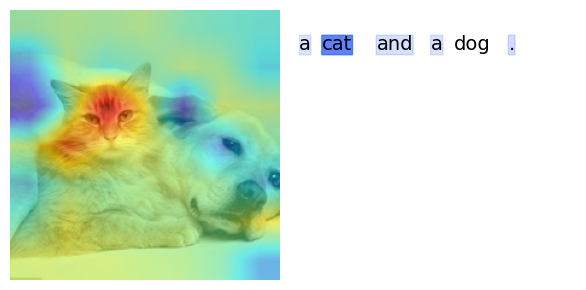

In [16]:
img_path = "images/cat-dog.jpg"
text = "a cat and a dog."

generate_plot(img_path,text,nib)

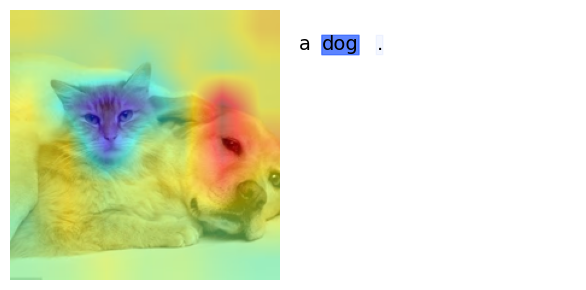

In [13]:
text = "a dog."
generate_plot(img_path,text,nib)

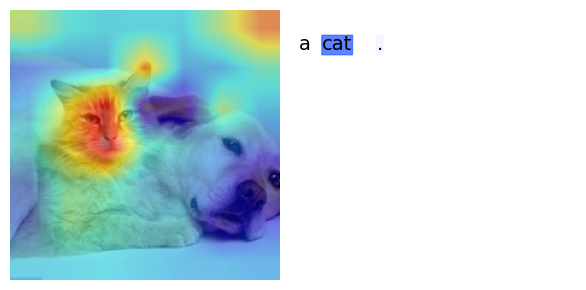

In [15]:
text = "a cat."
generate_plot(img_path,text,nib)